In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from data_loader import load_innovix_floresland, load_innovix_elbonie, load_bristor_zegoland
from Forecaster import Forecaster, ExternalAction
from tqdm import tqdm

DATA_ROOT = "./data"

In [2]:
def plot_gp(target=None, pred=None, std=None, samples=None,
        target_samples=None, figsize=None):
    plt.figure(figsize=figsize)
    if target is not None:
        plt.plot(target.index, target, c='black', label='target')
    if pred is not None:
        plt.scatter(pred.index, pred, c='tab:blue',
                label='predictions')
    if std is not None:
        plt.fill_between(pred.index, pred-1.96*std, pred+1.96*std,
                alpha=.3, fc='tab:blue', ec='None',
                label='95% C.I.')
    # Add scatter plots
    if samples is not None:
        try:
            x = samples.index
            y = samples.values
        except AttributeError:
            x = samples[0]
            y = samples[1]
        plt.scatter(x, y, color='tab:orange',
              label='samples', marker='x')
    if target_samples is not None:
        try:
            x = target_samples.index
            y = target_samples.values
        except AttributeError:
            x = target_samples[0]
            y = target_samples[1]
        plt.scatter(x, y,
                color='black', label='target', s=5)
    plt.legend()
    plt.grid(':')
    plt.tight_layout()

In [3]:
df = load_innovix_floresland(DATA_ROOT)
# df = load_innovix_elbonie(DATA_ROOT)
# df = load_bristor_zegoland(DATA_ROOT)

In [4]:
df_truth = pd.read_excel(os.path.join(DATA_ROOT, "INNOVIX_Floresland.xlsx"), sheet_name="Forecast volumes")
# df_truth = pd.read_excel(os.path.join(DATA_ROOT, "BRISTOR_Zegoland.xlsx"), sheet_name="Forecast volumes")
display(df_truth["Forecast Algorithm"].unique())

def get_df_truth(df_tr, algo, period="Monthly"):
    df_tr = df_tr[ df_tr["Forecast Algorithm"] == algo ]
    df_tr = df_tr[ df_tr["Data period"] == period ]
    return df_tr

array(['optimized tslmx', 'optimized arima', 'univariate xgboost',
       'multivariate xgboost', 'optimized ets', 'univariate arima',
       'optimized tbats'], dtype=object)

In [5]:
df.shape

(82, 224)

100%|██████████| 10/10 [00:00<00:00, 18.57it/s]


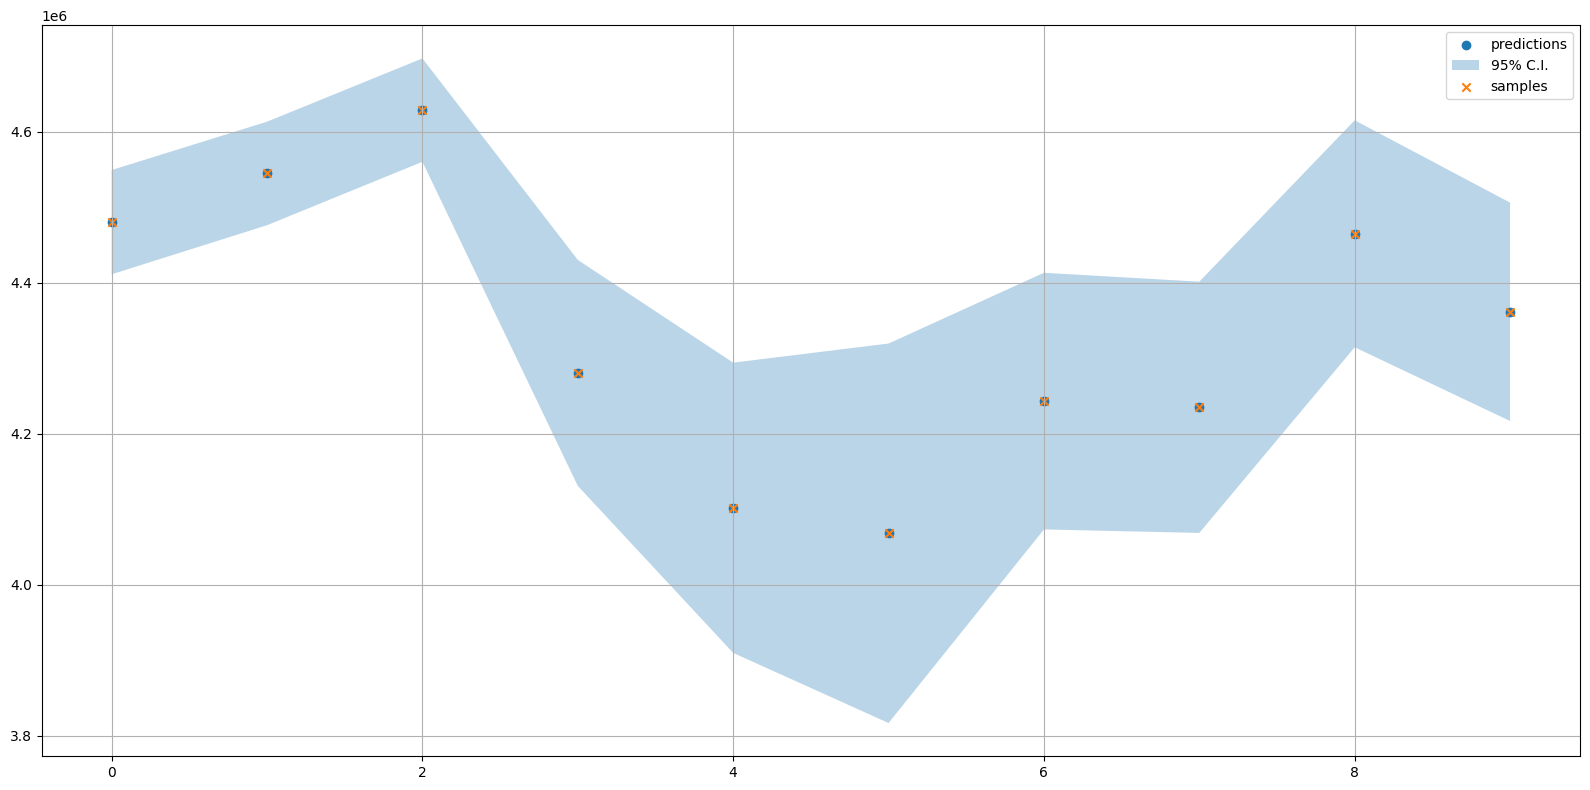

In [6]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


forecaster = Forecaster()
forecaster.fit(df)

preds, stds = forecaster.forecast(
    10,
    external_actions = [
        ExternalAction("YREX_months_of_treatment", 1.50, 85, 2, "update"),
        ExternalAction("INNOVIX_months_of_treatment", 0.5, 85, 2, "update"),
    ],
    maxlags = 15,
    verbose = True,
)


plot_gp(
    pred = pd.Series(index=range(len(preds)), data=preds), 
    samples = pd.Series(index=range(len(preds)), data=preds), 
    # samples = pd.Series(index=range(len(dff.iloc[-len(stds):]["ex_factory_volumes"])), data=dff.iloc[-len(stds):]["ex_factory_volumes"].values), 
    std = np.array(stds),
    figsize = (16, 8)
)

# for algo in df_truth["Forecast Algorithm"].unique():
#     df_tr = get_df_truth(df_truth, algo)
#     if len(df_tr) == 0:
#         df_tr = get_df_truth(df_truth, algo, period="Rolling 3 mth avg")


#     plt.plot(range(len(df_tr)), df_tr["Value"], label=algo)

#     print(
#         f"{algo:<25} "
#         f"MAPE: {mean_absolute_percentage_error(df_tr['Value'], preds[-len(df_tr['Value']):]):.5f}   "
#         f"MSE: {mean_squared_error(df_tr['Value'], preds[-len(df_tr['Value']):]):.5f} "
#     )

plt.legend()
plt.show()